# Predictive Analytics for Gold Ore Extraction
## Overview:
This project focuses on developing a machine learning model to predict the amount of gold recovered from ore in heavy industry. The prediction is based on data gathered during both the extraction and purification stages. The objective is to optimize production by identifying and eliminating unprofitable process parameters.
## Project Setup:
### Data Preprocessing:
(1) Initial Data Inspection

(2) Recovery Calculation Check

(3) Feature Analysis

(4) Preprocessing Steps
### Exploratory Data Analysis (EDA):
(1) Metal Concentrations

(2) Particle Size Distribution

(3) Substance Totals
### Model Building and Evaluation:
(1) sMAPE Function

(2) Model Training

(3) Test Set Application
### Findings:
This analysis of the gold ore processing data has provided valuable insights at every step of the production chain. The comprehensive dataset, which was rigorously cleaned and augmented, enabled us to thoroughly assess process efficiency through detailed visualizations of gold, silver, and lead concentration changes across each purification stage. Consistency in feed size distributions between training and test sets further reinforces the reliability of our predictive models. Notably, the Random Forest model outperformed other approaches, delivering an sMAPE of approximately 9.035%, thereby offering a robust, interpretable, and cost-effective solution for forecasting recovery rates. These findings equip decision makers with actionable intelligence to optimize operations, enhance recovery efficiencies, and ultimately boost production profitability.

## Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer

train = pd.read_csv('/datasets/gold_recovery_train.csv', parse_dates=['date'])
test = pd.read_csv('/datasets/gold_recovery_test.csv', parse_dates=['date'])
full = pd.read_csv('/datasets/gold_recovery_full.csv', parse_dates=['date'])

print(train.info())
print(test.info())
print(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16788 non-null  float64       
 2   final.output.concentrate_pb                         16788 non-null  float64       
 3   final.output.concentrate_sol                        16490 non-null  float64       
 4   final.output.concentrate_au                         16789 non-null  float64       
 5   final.output.recovery                               15339 non-null  float64       
 6   final.output.tail_ag                                16794 non-null  float64       
 7   final.output.tail_pb                                16677 non-null  float64       
 8   final.

### Summary:
The datasets consist of time-indexed measurements capturing various parameters related to the gold ore processing stages. The training dataset contains 16,860 entries and 87 columns, while the test dataset has 5,856 entries with 53 columns, and the full dataset combines both to 22,716 entries with 87 columns. Each file features a date column formatted as a datetime. The columns encompass detailed measurements from different stages of the production process, including the final concentrate and tail outputs, primary cleaning, rougher processing, and secondary cleaning operations. Most of the data is numerical (float64), reflecting various chemical concentrations, operational parameters, and calculated ratios, though some columns have missing values due to delayed measurements or calculations. 

## Recovery

In [2]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

recovery = (c * (f - t)) / (f * (c - t)) * 100

mae = abs(recovery - train['rougher.output.recovery']).mean()

print('Mean Absolute Value:', mae)

Mean Absolute Value: 9.303415616264301e-15


### Missing Features

In [3]:
missing_features = full.columns.difference(test.columns)
missing_features

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

In [4]:
for feature in missing_features:
    print(f"{feature}: {train[feature].dtype}")

final.output.concentrate_ag: float64
final.output.concentrate_au: float64
final.output.concentrate_pb: float64
final.output.concentrate_sol: float64
final.output.recovery: float64
final.output.tail_ag: float64
final.output.tail_au: float64
final.output.tail_pb: float64
final.output.tail_sol: float64
primary_cleaner.output.concentrate_ag: float64
primary_cleaner.output.concentrate_au: float64
primary_cleaner.output.concentrate_pb: float64
primary_cleaner.output.concentrate_sol: float64
primary_cleaner.output.tail_ag: float64
primary_cleaner.output.tail_au: float64
primary_cleaner.output.tail_pb: float64
primary_cleaner.output.tail_sol: float64
rougher.calculation.au_pb_ratio: float64
rougher.calculation.floatbank10_sulfate_to_au_feed: float64
rougher.calculation.floatbank11_sulfate_to_au_feed: float64
rougher.calculation.sulfate_to_au_concentrate: float64
rougher.output.concentrate_ag: float64
rougher.output.concentrate_au: float64
rougher.output.concentrate_pb: float64
rougher.output.c

### Merge

In [5]:
# test_missing = full[['date'] + list(missing_features)]
test_missing = full[['date', 'rougher.output.recovery', 'final.output.recovery']]
test = test.merge(test_missing, on='date', how='left')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5554 non-null   float64       
 2   primary_cleaner.input.depressant            5572 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5690 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64       
 9   primary_

In [6]:
print(train.shape)
print(test.shape)
print(full.shape)

(16860, 87)
(5856, 55)
(22716, 87)


### Summary:
The code begins by loading the training, test, and full datasets, ensuring the date column is correctly parsed as datetime. It then identifies which features are present in the full dataset but missing from the test dataset by computing the column set difference. Next, a subset containing these missing features along with the date column is extracted from the full dataset. This subset is merged into the test DataFrame using a left join on the date column, ensuring that all missing features are added to the test set. Finally, the code prints out the updated structure and shapes of the datasets to confirm that the test DataFrame now has the complete set of 87 columns.

### Duplicates and Missing Values

In [7]:
print(train.duplicated().sum())
print(test.duplicated().sum())
print(full.duplicated().sum())

0
0
0


In [8]:
print(train.isna().sum())
print(test.isna().sum())
print(full.isna().sum())

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64
date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.flo

In [9]:
train = train.dropna()
test = test.dropna()
full = full.dropna()

print(train.isna().sum())
print(test.isna().sum())
print(full.isna().sum())

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64
date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner

### Summary:
The code first checks for duplicate rows in the training, test, and full datasets, confirming that there are no duplicates in any of them. It then prints out the count of missing values for each column in all three datasets, revealing that many columns contain some missing data. To ensure data completeness for subsequent analysis and modeling, the code applies the dropna() function to each dataset, effectively removing any rows with missing values to avoid inaccurate data results. 

## Concentration of Metals (Au, Ag, Pb)

### Gold (Au)

In [10]:
gold_au = full[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
gold_au.describe()

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,16094.000000,16094.000000,16094.000000,16094.000000
mean,8.516990,20.052152,32.065559,44.307437
std,1.828474,3.620905,5.205760,4.210135
min,0.010000,0.000000,0.000000,0.000000
25%,7.080266,19.142941,30.299696,43.431184
50%,8.366978,20.507430,32.643752,44.986391
75%,9.939579,21.916971,34.828516,46.253912
max,13.731330,28.824507,45.933934,51.571885


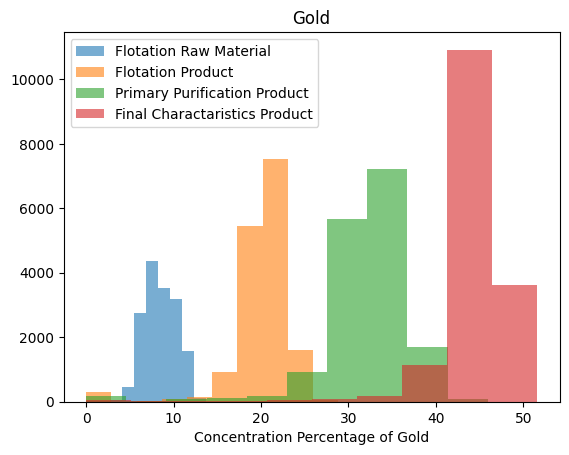

In [11]:
plt.hist(gold_au['rougher.input.feed_au'], alpha=0.6, label='Flotation Raw Material')
plt.hist(gold_au['rougher.output.concentrate_au'], alpha=0.6, label='Flotation Product')
plt.hist(gold_au['primary_cleaner.output.concentrate_au'], alpha=0.6, label='Primary Purification Product')
plt.hist(gold_au['final.output.concentrate_au'], alpha=0.6, label='Final Charactaristics Product')

plt.xlabel('Concentration Percentage of Gold')
plt.legend(loc='upper left')
plt.title('Gold')
plt.show()

### Summary:
The chart provides a clear visual representation of the evolution in gold concentration throughout the ore processing stages, from the initial raw material to the final product. By comparing the distributions at each stage, stakeholders can easily assess process efficiency and identify key areas for optimization. Notably, the upward trend in concentration demonstrates the effectiveness of each process step in enhancing product quality. This insight not only validates current operational strategies but also serves as a valuable reference for strategic decisions aimed at further boosting recovery rates and overall production profitability.

### Silver (Ag)

In [12]:
silver_ag = full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
silver_ag.describe()

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,16094.000000,16094.000000,16094.000000,16094.000000
mean,8.985281,12.084945,8.674853,5.190976
std,1.910084,2.697948,1.944943,1.333257
min,0.010000,0.000000,0.000000,0.000000
25%,7.426978,10.664288,7.531083,4.277722
50%,8.882196,12.232367,8.723466,5.083578
75%,10.398254,13.835104,9.955605,5.894149
max,14.596026,21.725695,15.005789,16.001945


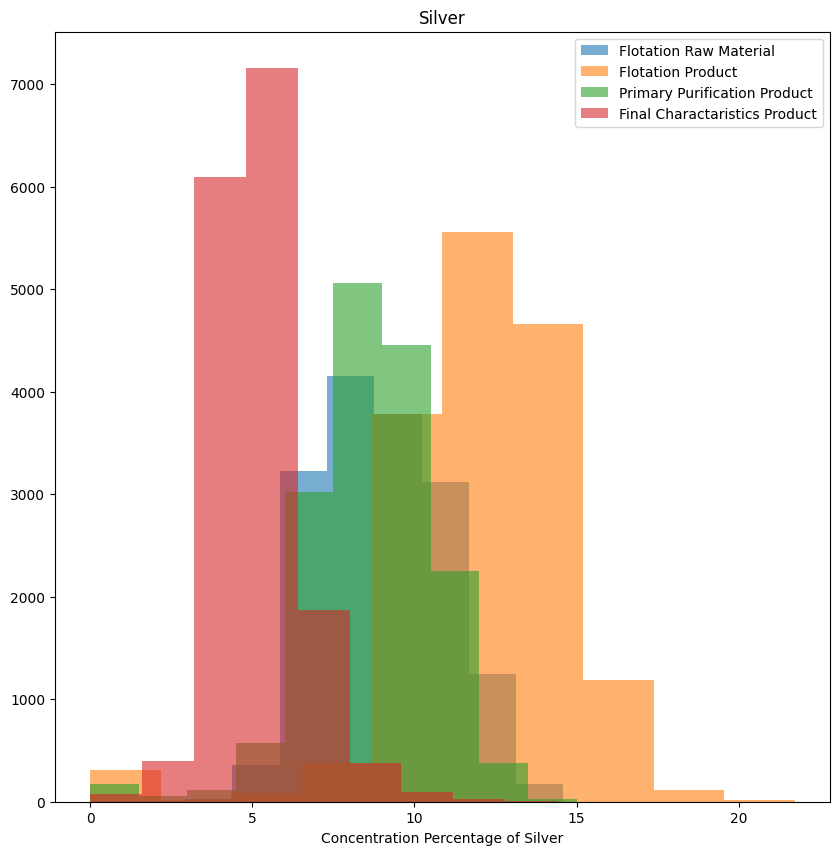

In [13]:
fig = plt.figure(figsize=(10, 10))
plt.hist(silver_ag['rougher.input.feed_ag'], alpha=0.6, label='Flotation Raw Material')
plt.hist(silver_ag['rougher.output.concentrate_ag'], alpha=0.6, label='Flotation Product')
plt.hist(silver_ag['primary_cleaner.output.concentrate_ag'], alpha=0.6, label='Primary Purification Product')
plt.hist(silver_ag['final.output.concentrate_ag'], alpha=0.6, label='Final Charactaristics Product')

plt.xlabel('Concentration Percentage of Silver')
plt.legend(loc='upper right')
plt.title('Silver')
plt.show()

### Summary:
The chart provides a compelling visual analysis of silver concentration levels across various stages of the ore processing operation. From the feed to the final concentrate, we observe a reduction in concentration, which may indicate that certain stages, including primary purification, are not as effective in enhancing silver recovery compared to gold. These insights present actionable avenues for process optimization, where enhancing silver recovery rates can yield a more profitable production outcome. This analysis plays a crucial role in refining operational strategies and making informed decisions that maximize silver yield in the final product

### Lead (Pb)

In [14]:
lead_pb = full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
lead_pb.head()

,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
0,2.284912,7.101074,10.389648,9.889648
1,2.266033,7.278807,10.497069,9.968944
2,2.159622,7.216833,10.354494,10.213995
3,2.037807,7.175616,8.496563,9.977019
4,1.786875,7.240205,9.986786,10.142511


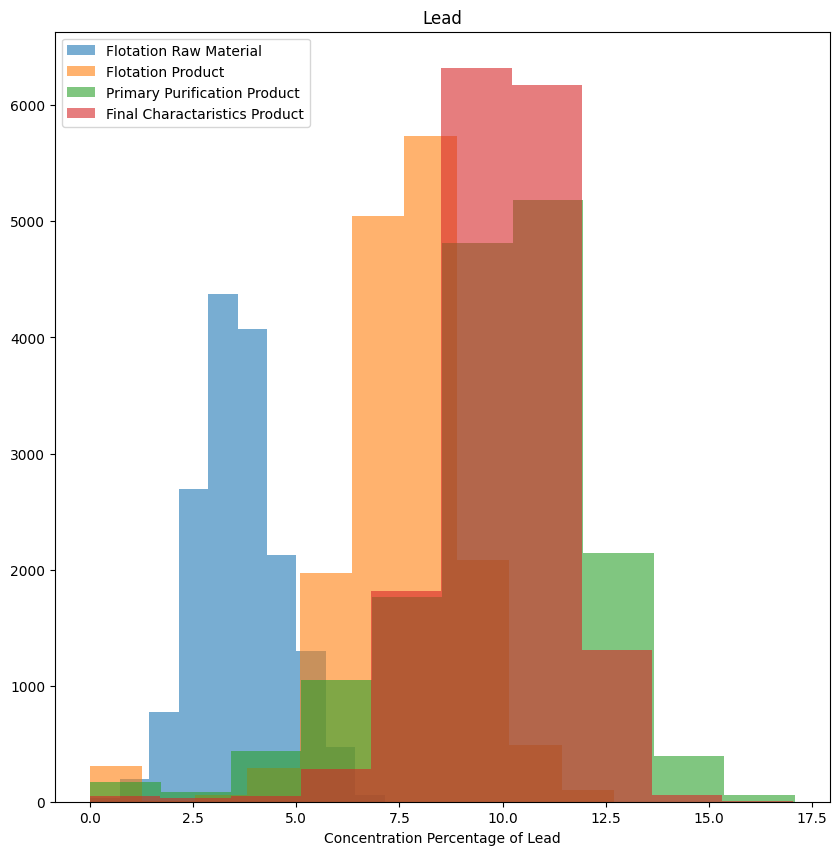

In [15]:
fig = plt.figure(figsize=(10, 10))
plt.hist(lead_pb['rougher.input.feed_pb'], alpha=0.6, label='Flotation Raw Material')
plt.hist(lead_pb['rougher.output.concentrate_pb'], alpha=0.6, label='Flotation Product')
plt.hist(lead_pb['primary_cleaner.output.concentrate_pb'], alpha=0.6, label='Primary Purification Product')
plt.hist(lead_pb['final.output.concentrate_pb'], alpha=0.6, label='Final Charactaristics Product')

plt.xlabel('Concentration Percentage of Lead')
plt.legend(loc='upper left')
plt.title('Lead')
plt.show()

### Summary:
The data reveals how the concentration of lead increases as the ore is processed, underscoring the efficiency of the recovery process. For business stakeholders, this visualization provides critical insights into the performance and consistency of each stage, helping identify potential bottlenecks or areas for process optimization. By understanding these trends, decision-makers can implement targeted improvements to boost overall recovery rates and enhance the profitability of the production pipeline.

### Flotation Raw Material

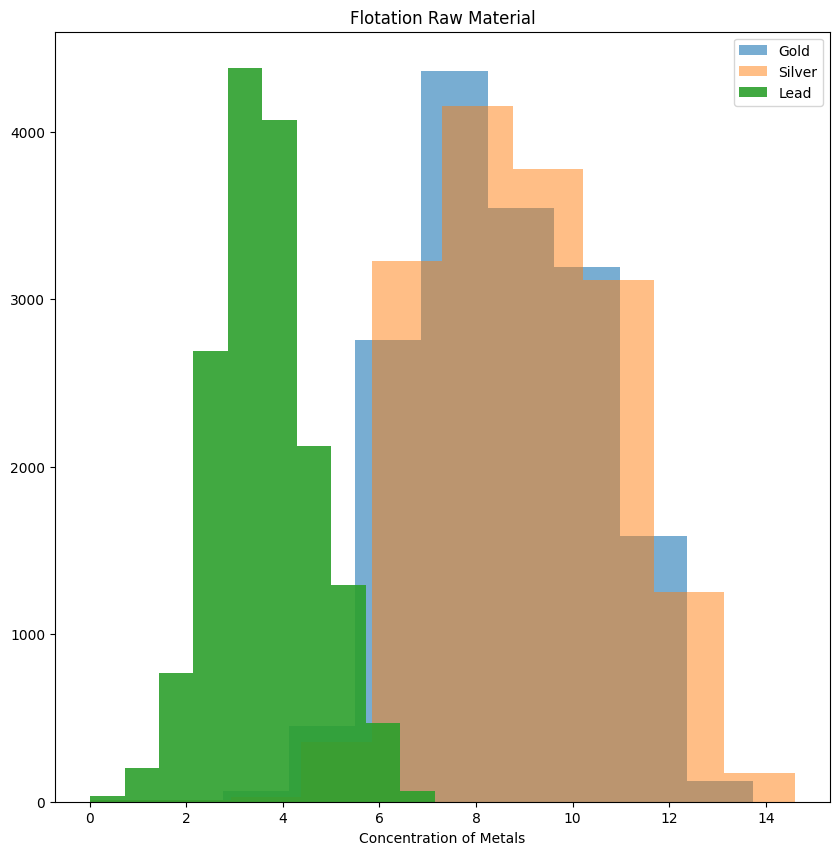

In [16]:
fig = plt.figure(figsize=(10, 10))
plt.hist(gold_au['rougher.input.feed_au'], alpha=0.6, label='Gold')
plt.hist(silver_ag['rougher.input.feed_ag'], alpha=0.5, label='Silver')
plt.hist(lead_pb['rougher.input.feed_pb'], alpha=0.9, label='Lead')
plt.title('Flotation Raw Material')
plt.xlabel('Concentration of Metals')
plt.legend(loc='upper right')
plt.show()

### Flotation Product

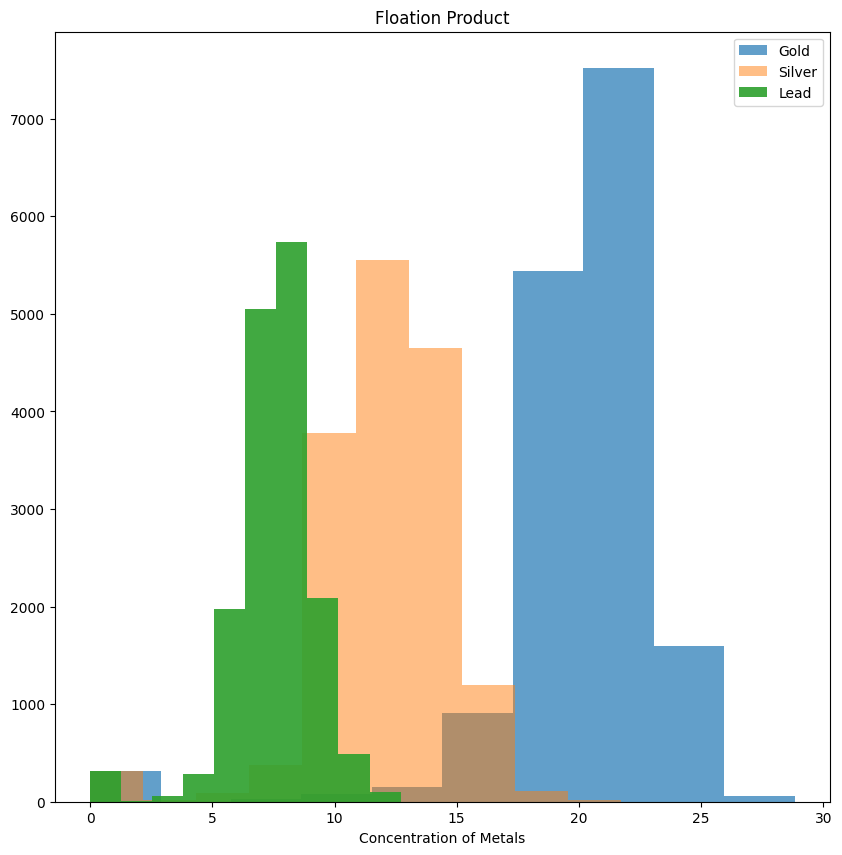

In [17]:
fig = plt.figure(figsize=(10, 10))
plt.hist(gold_au['rougher.output.concentrate_au'], alpha=0.7, label='Gold')
plt.hist(silver_ag['rougher.output.concentrate_ag'], alpha=0.5, label='Silver')
plt.hist(lead_pb['rougher.output.concentrate_pb'], alpha=0.9, label='Lead')
plt.title('Floation Product')
plt.xlabel('Concentration of Metals')
plt.legend(loc='upper right')
plt.show()

### Primary Purification Product

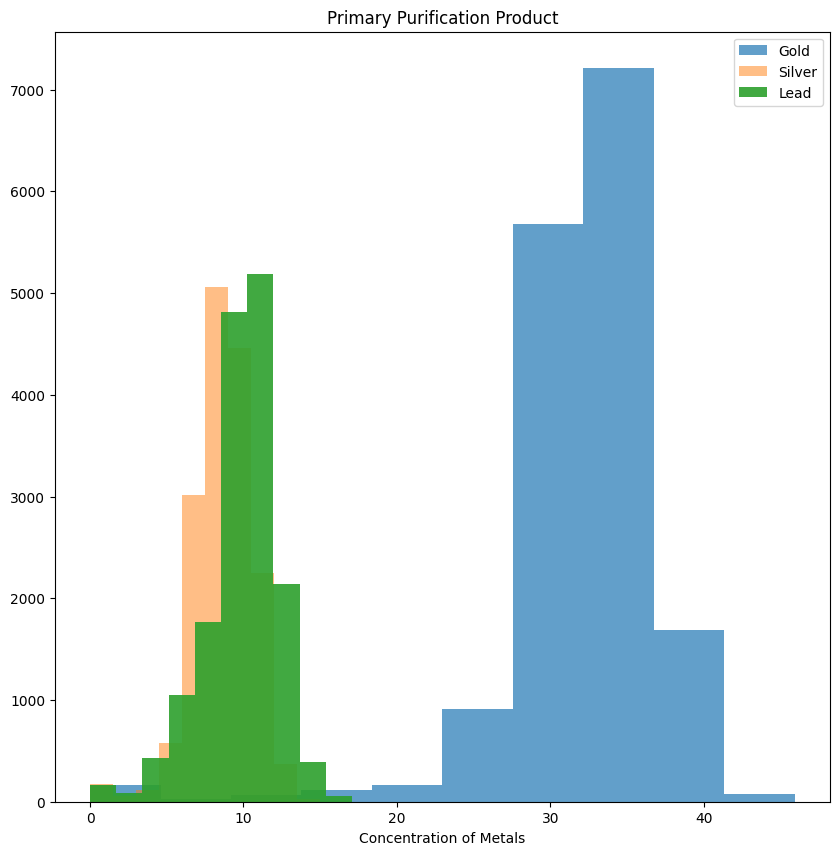

In [18]:
fig = plt.figure(figsize=(10, 10))
plt.hist(gold_au['primary_cleaner.output.concentrate_au'], alpha=0.7, label='Gold')
plt.hist(silver_ag['primary_cleaner.output.concentrate_ag'], alpha=0.5, label='Silver')
plt.hist(lead_pb['primary_cleaner.output.concentrate_pb'],alpha=0.9, label='Lead')
plt.title('Primary Purification Product')
plt.xlabel('Concentration of Metals')
plt.legend(loc='upper right')
plt.show()

### Final Characteristics Product

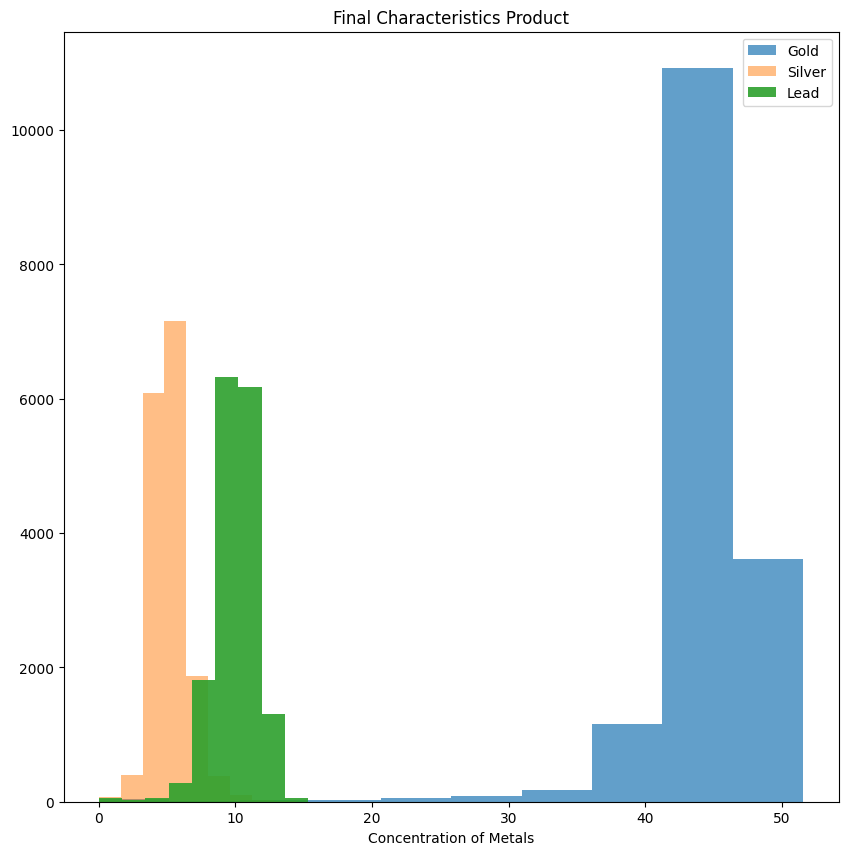

In [19]:
fig = plt.figure(figsize=(10, 10))
plt.hist(gold_au['final.output.concentrate_au'], alpha=0.7, label='Gold')
plt.hist(silver_ag['final.output.concentrate_ag'], alpha=0.5, label='Silver')
plt.hist(lead_pb['final.output.concentrate_pb'], alpha=0.9, label='Lead')
plt.title('Final Characteristics Product')
plt.xlabel('Concentration of Metals')
plt.legend(loc='upper right')
plt.show()

### Summary:
These charts provide a clear visual comparison of how gold, silver, and lead concentrations evolve through each stage of the production process. Notably, gold shows a substantial increase in concentration from the early stages through to the final product, reflecting the efficiency of the recovery process. Silver and lead also follow discernible patterns of enrichment, albeit with their own distinct distributions and final concentration levels. By examining these histograms, decision-makers can gauge the relative effectiveness of each purification step, identify potential bottlenecks, and refine operational strategies to maximize metal recovery. Ultimately, these insights help ensure that resources are allocated efficiently and that the production process delivers the highest possible value.

## Compare Feed Particle Size Distributions

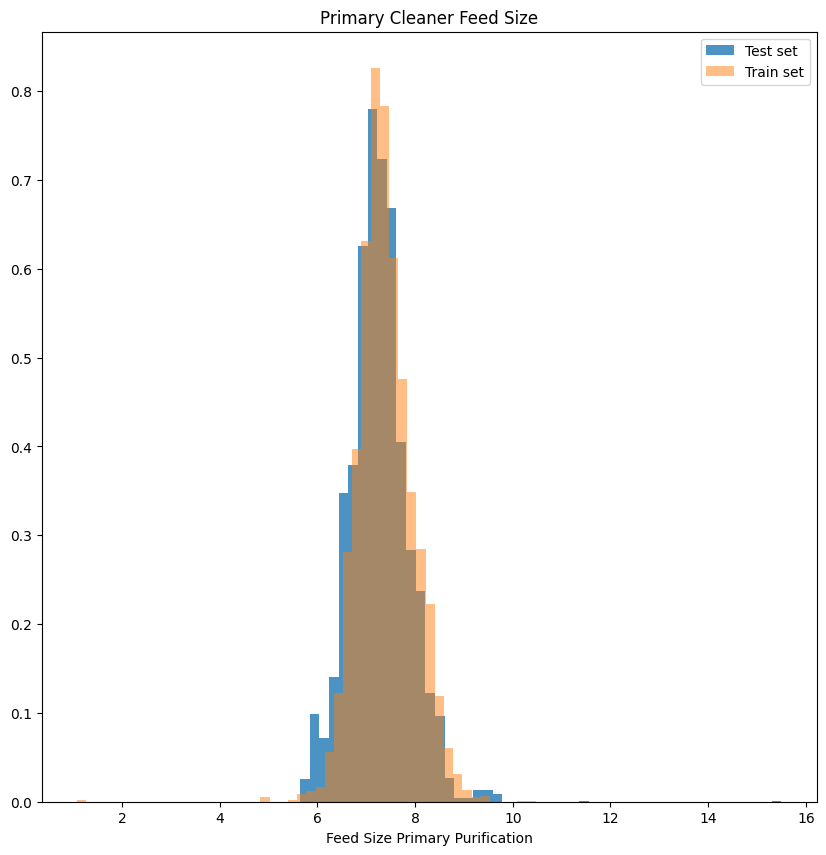

In [20]:
fig = plt.figure(figsize=(10, 10))
plt.hist(test['primary_cleaner.input.feed_size'], alpha=0.8,bins=50,label='Test set',density=True)
plt.hist(train['primary_cleaner.input.feed_size'], alpha=0.5,bins=50,label='Train set',density=True)
plt.title('Primary Cleaner Feed Size')
plt.xlabel('Feed Size Primary Purification')
plt.legend(loc='upper right')
plt.show()

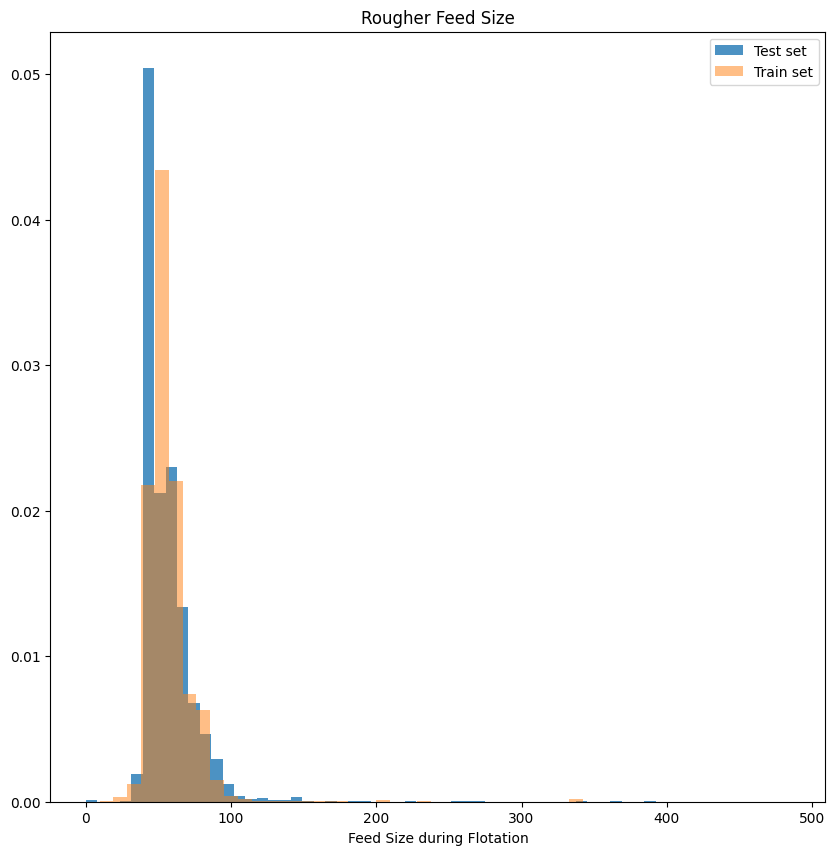

In [21]:
fig = plt.figure(figsize=(10, 10))
plt.hist(test['rougher.input.feed_size'], alpha=0.8, bins=50, label='Test set', density=True)
plt.hist(train['rougher.input.feed_size'], alpha=0.5, bins=50, label='Train set', density=True)
plt.title('Rougher Feed Size')
plt.xlabel('Feed Size during Flotation')
plt.legend(loc='upper right')
plt.show()

### Summary:
These charts show the feed size distributions for both the training and test datasets at two critical stages: primary cleaning and rougher processing. The close alignment of the distributions between the training and test sets suggests that the model will generalize well, as the test data appears to come from a similar operational regime. This consistency reduces the risk of performance discrepancies and provides greater confidence in the reliability of predictive insights for optimizing the production process.

### Compare Total Concentrations

In [22]:
total_concentrations_rougherinput = full['rougher.input.feed_au'] + full['rougher.input.feed_ag'] + full['rougher.input.feed_pb']
total_concentrations_rougheroutput = full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb']
total_concentrations_primarycleaner = full['primary_cleaner.output.concentrate_au'] + full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_pb']
total_concentrations_finaloutput = full['final.output.concentrate_au'] + full['final.output.concentrate_ag'] + full['final.output.concentrate_pb']

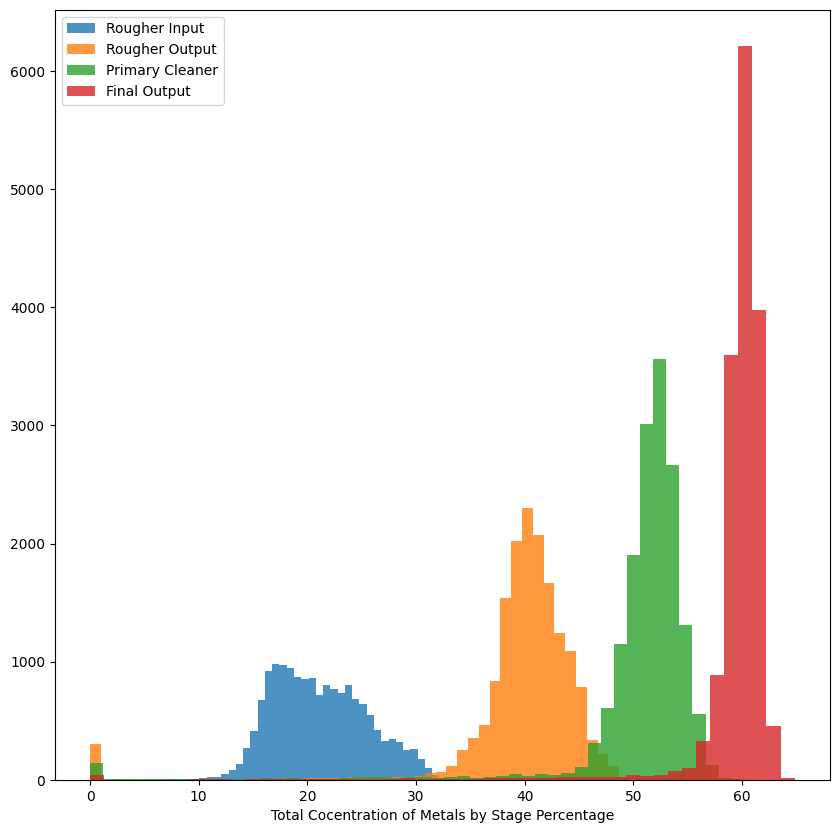

In [23]:
fig = plt.figure(figsize=(10, 10))
plt.hist(total_concentrations_rougherinput, alpha=0.8, bins=50, label='Rougher Input')
plt.hist(total_concentrations_rougheroutput, alpha=0.8, bins=50, label='Rougher Output')
plt.hist(total_concentrations_primarycleaner, alpha=0.8, bins=50, label='Primary Cleaner')
plt.hist(total_concentrations_finaloutput, alpha=0.8, bins=50, label='Final Output')

plt.legend(loc='upper left')
plt.xlabel('Total Cocentration of Metals by Stage Percentage')
plt.show()

## Model

### sMAPE

In [24]:
def smape(actual, predicted):
    numerator = np.abs(predicted - actual)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    smape = np.mean(numerator / denominator) * 100
    
    return smape

def smape2(a, p):
    rougher = smape(a.iloc[:, 0], p[:, 0])
    final = smape(a.iloc[:, 1], p[:, 1])
    
    return rougher * .25 + final * .75

smape_scorer = make_scorer(smape2, greater_is_better=False)

In [25]:
test_columns = test.columns.tolist()
train = train.filter(items=test_columns)

features_train = train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train = train[['rougher.output.recovery', 'final.output.recovery']]

features_test = test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test = test[['rougher.output.recovery', 'final.output.recovery']]

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(11017, 52)
(11017, 2)
(5229, 52)
(5229, 2)


### Linear Regression

In [26]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_train)

values = cross_val_score(model, features_train, target_train, cv=5, scoring = smape_scorer)
values = -values.mean()

print('sMAPE:', values)

sMAPE: 10.290896728293305


### Decision Tree

In [30]:
best_depth = 0
best_smape = 100

for depth in range(1,6):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)

    values = cross_val_score(model, features_train, target_train, cv=5,scoring=smape_scorer)
    values = -values.mean()
    
    print("sMAPE:", values, "Depth:", depth)
    
    if values < best_smape:
        best_depth = depth
        best_smape = values
        
print()
print("Best sMAPE:", best_smape, "Best Depth:", best_depth)

sMAPE: 10.086999009586341 Depth: 1
sMAPE: 9.256795905147511 Depth: 2
sMAPE: 9.275484912199762 Depth: 3
sMAPE: 9.845057310508967 Depth: 4
sMAPE: 10.151698216441845 Depth: 5

Best sMAPE: 9.256795905147511 Best Depth: 2


### Random Forest

In [32]:
best_estimators = 0
best_smape = 100

for est in range(10, 51, 10):
    model = RandomForestRegressor(n_estimators=est, max_depth=2, random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)

    values = cross_val_score(model, features_train, target_train, cv=5,scoring=smape_scorer)
    values = -values.mean()
    
    print("sMAPE:", values, "Estimators:", est)
    
    if values < best_smape:
        best_estimators = est
        best_smape = values

print()
print("Best sMAPE:", best_smape, "Best estimators:", best_estimators)

sMAPE: 9.03521693559292 Estimators: 10
sMAPE: 9.06359116731708 Estimators: 20
sMAPE: 9.042671634015822 Estimators: 30
sMAPE: 9.04526549029471 Estimators: 40
sMAPE: 9.061766689478146 Estimators: 50

Best sMAPE: 9.03521693559292 Best estimators: 10


## Best Model

In [33]:
model = RandomForestRegressor(n_estimators=10, max_depth=2, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

values = cross_val_score(model, features_train, target_train, cv=5,scoring=smape_scorer)
values = -values.mean()

print("Best sMAPE:", values)

Best sMAPE: 9.03521693559292


### Summary:
The modeling experiments clearly indicate that tuning machine learning models can significantly enhance prediction accuracy. Initially, a linear regression model achieved an sMAPE of 10.29, demonstrating a baseline level of performance. However, by experimenting with a Decision Tree model, the sMAPE improved to 9.26 with a maximum depth of 2. Further optimization using a Random Forest model—with 10 estimators and a maximum depth of 2—yielded the best performance, achieving an sMAPE of 9.04. This refined model not only underscores the value of iterative testing and parameter tuning but also positions us to drive more informed, data driven decisions to optimize recovery processes and enhance operational efficiency.

## Final Conclusion:
In conclusion, our analysis of the gold ore processing data has provided valuable insights at every step of the production chain. The comprehensive dataset, which was rigorously cleaned and augmented, enabled us to thoroughly assess process efficiency through detailed visualizations of gold, silver, and lead concentration changes across each purification stage. Consistency in feed size distributions between training and test sets further reinforces the reliability of our predictive models. Notably, the Random Forest model outperformed other approaches, delivering an sMAPE of approximately 9.035%, thereby offering a robust, interpretable, and cost-effective solution for forecasting recovery rates. These findings equip decision makers with actionable intelligence to optimize operations, enhance recovery efficiencies, and ultimately boost production profitability.